Clone official HNN repositry

In [ ]:
!git clone https://github.com/greydanus/hamiltonian-nn.git

In [ ]:
cd hamiltonian-nn/

Prepare scripts for raindrops falling

In [8]:
!tar -zxvf experiment-raindrops.tar.gz

experiment-raindrops/
experiment-raindrops/__pycache__/
experiment-raindrops/__pycache__/data.cpython-310.pyc
experiment-raindrops/.ipynb_checkpoints/
experiment-raindrops/train.py
experiment-raindrops/raindrops-hnn.tar
experiment-raindrops/data.py


Training

In [12]:
!python3 experiment-raindrops/train.py --verbose --name raindrops --noise 0.5

Training HNN model:
step 0, train_loss 4.3501e+01, test_loss 4.3048e+01
step 200, train_loss 1.3799e-01, test_loss 1.4982e-01
step 400, train_loss 6.3683e-02, test_loss 7.4808e-02
step 600, train_loss 3.5387e-02, test_loss 4.3117e-02
step 800, train_loss 2.5840e-02, test_loss 3.1837e-02
step 1000, train_loss 2.2574e-02, test_loss 2.7789e-02
step 1200, train_loss 2.1048e-02, test_loss 2.5939e-02
step 1400, train_loss 2.2968e-02, test_loss 2.6084e-02
step 1600, train_loss 1.9823e-02, test_loss 2.4547e-02
step 1800, train_loss 1.9543e-02, test_loss 2.4265e-02
step 2000, train_loss 1.9362e-02, test_loss 2.4083e-02
Final train loss 1.9362e-02 +/- 1.9154e-03
Final test loss 2.4083e-02 +/- 2.3686e-03


Inference

In [13]:
import torch
from hnn import HNN
from nn_models import MLP
import matplotlib.pyplot as plt
import numpy as np

In [14]:
nn_model = MLP(2, 200, 2, 'tanh')
model = HNN(2, differentiable_model=nn_model)
model.load_state_dict(torch.load('experiment-raindrops/raindrops-hnn.tar'))

q = 0
p = 0
dt = 0.1 #[s]
qs = [0]
ps = [0]
ts = [0]
nstep = 100
for t in range(nstep - 1):
    x = torch.tensor([[q, p]], requires_grad=True, dtype=torch.float32)
    [dqdt, dpdt] = model.time_derivative(x)[0]
    q = q + dqdt * dt
    p = p + dpdt * dt
    ts.append((t+1) * dt)
    qs.append(q.detach().numpy())
    ps.append(p.detach().numpy())

Plot

In [15]:
import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp


def my_get_trajectory(noise_std=0.0, **kwargs):

  def my_func(t,x):
    p, q = x
    return [g * np.exp(-k*t), g * (1 - np.exp(-k*t)) / k]

  # Initial Values
  T_INITIAL = 0  # [s]
  p0 = 0.0
  q0 = 0.0
  init = [p0, q0]

  # Params for Phys.
  k = 1  # [1/s]
  g = 9.8  # [m/s]

  # Params for Calc.
  T_FINAL = 10  # [s]
  T_STEP = 0.1  # [s]

  n_steps = (T_FINAL - T_INITIAL) / T_STEP
  t_eval = T_INITIAL + np.arange(0, n_steps) * T_STEP
  t_span = [T_INITIAL, T_FINAL]

  result = solve_ivp(my_func, t_span, init, method='RK45', t_eval=t_eval)
  p = result.y[0,:]
  q = result.y[1,:]
  dpdt = g * np.exp(-k*t_eval)
  dqdt = g * (1 - np.exp(-k*t_eval)) / k

  # add noise
  q += np.random.randn(*q.shape)*noise_std
  p += np.random.randn(*p.shape)*noise_std
  return q, p, dqdt, dpdt, t_eval


def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = my_get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [16]:
data = get_dataset(seed=0)
ps_hat = data['x'][:100,1].flatten()
ps_hat = ps_hat.tolist()
qs_hat = data['x'][:100,0].flatten()
qs_hat = qs_hat.tolist()

In [17]:
g = np.repeat([9.8],100)

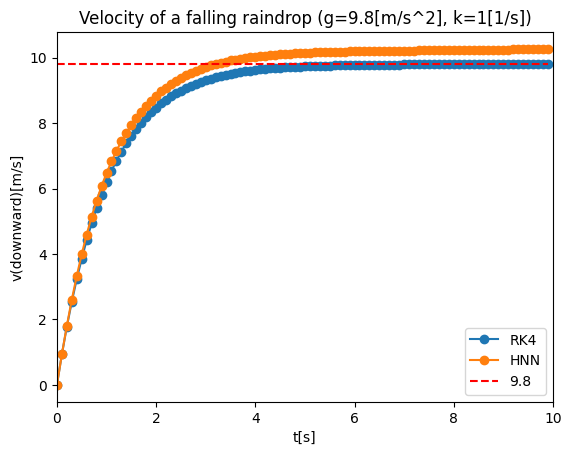

In [20]:
plt.title('Velocity of a falling raindrop (g=9.8[m/s^2], k=1[1/s])')
plt.xlim([0,10])
plt.xlabel('t[s]')
plt.ylabel('v(downward)[m/s]')
plt.plot(ts, ps_hat, 'o-', label='RK4')
plt.plot(ts, ps, 'o-', label='HNN')
plt.plot(ts, g, label='9.8', ls='dashed', c='red')
plt.legend()

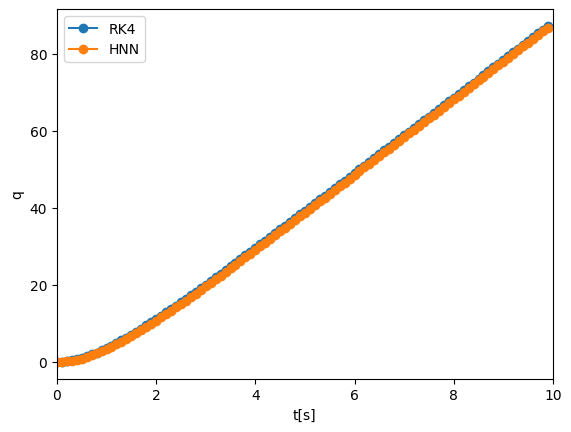

In [21]:
plt.xlim([0,10])
plt.xlabel('t[s]')
plt.ylabel('q')
plt.plot(ts, qs_hat, 'o-', label='RK4')
plt.plot(ts, qs, 'o-', label='HNN')
plt.legend()